### Multiclass Semantic Segmentation of Aerial Imagery Using ViT-based & CNN-based UNet Models

This project focuses on the comparison of Vision-Transformers-based (UNETR) and CNN-based UNet Models for the task of Multiclass Semantic Segmentation of Aerial Images. 

In [17]:
# Import libraries
import os
import cv2
import IPython
import numpy as np
import pandas as pd
from PIL import Image
from patchify import patchify
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras import backend as K
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras.models import Model , load_model
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

In [18]:
# Image config
img_size = 256 
num_channels = 3
input_shape = (img_size, img_size, num_channels)

# Transformers encoder hyperparameters config
patch_size = 16
num_patches = (img_size // patch_size) * (img_size // patch_size)
mlp_dim = 3072  # dimensionality of the hidden layers in the Multi-Layer Perceptron (MLP) component of the mode
num_heads = 12  # Number of attention heads in the multi-head attention layer
hidden_dim = 768 # the size of the feature vectors (embeddings) for representing the input data
dropout_rate= 0.1
transformer_layers = 12 # Number of transformer blocks
flat_patches_shape = (num_patches, patch_size*patch_size*num_channels)

# MinMaxScaler for rescaling each variable to a range of 0-1
scaler = MinMaxScaler()

In [19]:
# The dataset consists of 72 aerial images of Dubai & annotated with pixel-wise semantic segmentation in 6 classes. 
# https://www.kaggle.com/datasets/humansintheloop/semantic-segmentation-of-aerial-imagery
root_folder = './data/SemanticSegmentationDataset'

In [20]:
# Raw input images are of various sizes, thus we should capture all images into numpy arrays, 
# then crop them into the nearest size which is divisible by 256 (img_size), following this cut them into a fixed-size and extract 256X256 patches.
# In total => 1035 patches
img_dataset =[]

for path , subdirs, files in os.walk(root_folder):
    
    # name of each direcory
    dir_name = path.split(os.path.sep)[-1]
    
    if dir_name== 'images':
        print('-----------------------------------------------\n', 'Image Directory Path: ', path)
        
        # list of images in each 'image' directory
        images_lst = os.listdir(path)
        images_lst.sort()
        
        for i , img in enumerate(images_lst):
            if img.endswith('.jpg'): 
                print('-------------------\n', img)
                
                #read images in RGB
                image = cv2.imread(path+ '/' + img , 1)
                print(' image shape: ',image.shape)
                
                # images are cropped from their top and left corners to the nearest size that is divisible by 256
                sizeX = (image.shape[1] // img_size) * img_size
                sizeY = (image.shape[0] // img_size) * img_size
                image = Image.fromarray(image)
                image = image.crop((0,0,sizeX,sizeY))
                
                # convert images into numpy array
                image = np.array(image)

                # cut up images into non-overlapped 256x256 pieces
                patched_imgs = patchify(image , (img_size,img_size,3) , step= img_size)
                print(' patche shape: ',patched_imgs.shape)
                
                for i in range(patched_imgs.shape[0]):
                    for j in range(patched_imgs.shape[1]):
                        single_patch_img = patched_imgs[i,j,:,:]

                        # normalize images via MinMaxScaler => value between 0 and 1
                        single_patch_img = scaler.fit_transform(single_patch_img.reshape(-1, single_patch_img.shape[-1])).reshape(single_patch_img.shape)
                        single_patch_img = single_patch_img[0]
                        
                        # add all patches to a list
                        img_dataset.append(single_patch_img)

-----------------------------------------------
 Image Directory Path:  ./data/SemanticSegmentationDataset\Tile 1\images
-------------------
 image_part_001.jpg
 image shape:  (644, 797, 3)
 patche shape:  (2, 3, 1, 256, 256, 3)
-------------------
 image_part_002.jpg
 image shape:  (644, 797, 3)
 patche shape:  (2, 3, 1, 256, 256, 3)
-------------------
 image_part_003.jpg
 image shape:  (644, 797, 3)
 patche shape:  (2, 3, 1, 256, 256, 3)
-------------------
 image_part_004.jpg
 image shape:  (643, 797, 3)
 patche shape:  (2, 3, 1, 256, 256, 3)
-------------------
 image_part_005.jpg
 image shape:  (643, 797, 3)
 patche shape:  (2, 3, 1, 256, 256, 3)
-------------------
 image_part_006.jpg
 image shape:  (643, 797, 3)
 patche shape:  (2, 3, 1, 256, 256, 3)
-------------------
 image_part_007.jpg
 image shape:  (644, 797, 3)
 patche shape:  (2, 3, 1, 256, 256, 3)
-------------------
 image_part_008.jpg
 image shape:  (644, 797, 3)
 patche shape:  (2, 3, 1, 256, 256, 3)
---------------

In [21]:
msk_dataset = [] 

for path, subdirs, files in os.walk(root_folder):

    # name of each direcory
    dirname = path.split(os.path.sep)[-1]
    
    if dirname == 'masks':
        print('-----------------------------------------------\n', 'Mask Directory Path: ', path)
        
        # list of masks in each 'mask' directory
        masks_lst = os.listdir(path)
        masks_lst.sort()
        
        
        for i, msk in enumerate(masks_lst):  
            if msk.endswith(".png"):
                print('-------------------\n' ,msk)
               
                #Read each mask as RGB
                mask = cv2.imread(path+"/"+msk, 1)
                mask = cv2.cvtColor(mask,cv2.COLOR_BGR2RGB)
                print(' mask shape: ', mask.shape)
                
                # masks are cropped from their top and left corners to the nearest size that is divisible by 256
                sizeX = (mask.shape[1]//img_size)*img_size 
                sizeY = (mask.shape[0]//img_size)*img_size 
                mask = Image.fromarray(mask)
                mask = mask.crop((0 ,0, sizeX, sizeY)) 
                
                # convert masks into numpy array
                mask = np.array(mask)             
       
                # cut up masks into 256x256 pieces for data augmentation
                patched_masks = patchify(mask , (img_size,img_size,3) , step= img_size)
                print(' patche shape: ', patched_masks.shape)
        
                for i in range(patched_masks.shape[0]):
                    for j in range(patched_masks.shape[1]):
                        
                        single_patch_mask = patched_masks[i,j,:,:]
                        single_patch_mask = single_patch_mask[0]  
                        
                        # add all patched masks to a list
                        msk_dataset.append(single_patch_mask) 

-----------------------------------------------
 Mask Directory Path:  ./data/SemanticSegmentationDataset\Tile 1\masks
-------------------
 image_part_001.png
 mask shape:  (644, 797, 3)
 patche shape:  (2, 3, 1, 256, 256, 3)
-------------------
 image_part_002.png
 mask shape:  (644, 797, 3)
 patche shape:  (2, 3, 1, 256, 256, 3)
-------------------
 image_part_003.png
 mask shape:  (644, 797, 3)
 patche shape:  (2, 3, 1, 256, 256, 3)
-------------------
 image_part_004.png
 mask shape:  (643, 797, 3)
 patche shape:  (2, 3, 1, 256, 256, 3)
-------------------
 image_part_005.png
 mask shape:  (643, 797, 3)
 patche shape:  (2, 3, 1, 256, 256, 3)
-------------------
 image_part_006.png
 mask shape:  (643, 797, 3)
 patche shape:  (2, 3, 1, 256, 256, 3)
-------------------
 image_part_007.png
 mask shape:  (644, 797, 3)
 patche shape:  (2, 3, 1, 256, 256, 3)
-------------------
 image_part_008.png
 mask shape:  (644, 797, 3)
 patche shape:  (2, 3, 1, 256, 256, 3)
-------------------
 imag

In [22]:
img_dataset = np.array(img_dataset)
msk_dataset =  np.array(msk_dataset)

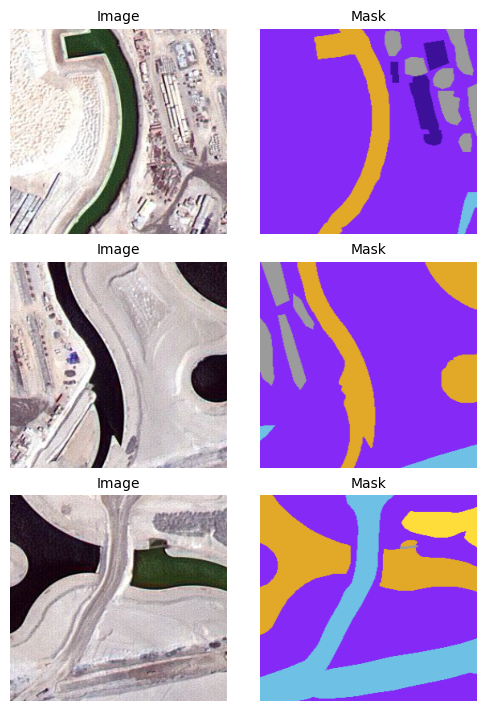

In [23]:
# Visualise patched images & their corresponding masks
count = 0
i = 0
fig, axs = plt.subplots(3, 2, figsize=(5, 7), constrained_layout=True)

for mask in msk_dataset:
    if (mask.all()):
        # read images
        axs[count][0].imshow(cv2.resize(img_dataset[i], (270,256)))
        axs[count][0].set_title('Image', fontdict = {'fontsize':10})
        axs[count][0].axis(False)
        
        # read masks
        axs[count][1].imshow(cv2.resize(msk_dataset[i], (270,256)))
        axs[count][1].set_title('Mask' , fontdict = {'fontsize':10})
        axs[count][1].axis(False)

        count +=1
    i += 1
    if (count==3):
        break
        
plt.show()

In [24]:
# Mask are RGB and information is provided in HEX color code, so we need to:
# 1) Convert HEX labels to RGB values--------------------------------------------------------------------------
Building = '#3C1098'.lstrip('#')
Building = np.array(tuple(int(Building[i:i+2], 16) for i in (0, 2, 4)))
print('Building :' , Building)

Land = '#8429F6'.lstrip('#')
Land = np.array(tuple(int(Land[i:i+2], 16) for i in (0, 2, 4)))
print('Land :' , Land)

Road = '#6EC1E4'.lstrip('#') 
Road = np.array(tuple(int(Road[i:i+2], 16) for i in (0, 2, 4))) 
print('Road :' , Road)

Vegetation =  'FEDD3A'.lstrip('#') 
Vegetation = np.array(tuple(int(Vegetation[i:i+2], 16) for i in (0, 2, 4)))
print('Vegetation :' , Vegetation)

Water = 'E2A929'.lstrip('#') 
Water = np.array(tuple(int(Water[i:i+2], 16) for i in (0, 2, 4))) 
print('Water :' , Water)

Unlabeled = '#9B9B9B'.lstrip('#') 
Unlabeled = np.array(tuple(int(Unlabeled[i:i+2], 16) for i in (0, 2, 4)))
print('Unlabeled :' , Unlabeled)


# 2) Convert RGB labels to integer values--------------------------------------------------------------------------
def rgb_to_2D_label(msk_dt):
    # create a new array of given shape and type of each row of mask dataset, filled with zeros
    label_seg = np.zeros(msk_dt.shape, dtype = np.uint8)
    
    label_seg [np.all(msk_dt == Building,axis=-1)] = 0
    label_seg [np.all(msk_dt==Land,axis=-1)] = 1
    label_seg [np.all(msk_dt==Road,axis=-1)] = 2
    label_seg [np.all(msk_dt==Vegetation,axis=-1)] = 3
    label_seg [np.all(msk_dt==Water,axis=-1)] = 4
    label_seg [np.all(msk_dt==Unlabeled,axis=-1)] = 5
    
    label_seg = label_seg[:,:,0]  
    return label_seg

labels = []
for i in range(msk_dataset.shape[0]):
    label = rgb_to_2D_label(msk_dataset[i])
    labels.append(label)

labels = np.array(labels) 
labels = np.expand_dims(labels, axis=3)
print("-----------------------------")
print(labels.shape)


# 3) one-hot encode labels, since it's a multiclass segmentation task ----------------------------------------------
print("-----------------------------")
print("all labels : ", np.unique(labels))
num_classes = len(np.unique(labels)) #6
labels_cat = to_categorical(labels, num_classes=num_classes)

Building : [ 60  16 152]
Land : [132  41 246]
Road : [110 193 228]
Vegetation : [254 221  58]
Water : [226 169  41]
Unlabeled : [155 155 155]
-----------------------------
(1305, 256, 256, 1)
-----------------------------
all labels :  [0 1 2 3 4 5]


In [25]:
# split data into training & testing dataset
X_train, X_test, y_train, y_test = train_test_split(img_dataset, labels_cat, test_size = 0.20, random_state = 42)
print('X_train shape: ', X_train.shape)
print('y_train shape: ',y_train.shape)
print('X_test shape: ',X_test.shape)
print('y_test shape: ',y_test.shape)

X_train shape:  (1044, 256, 256, 3)
y_train shape:  (1044, 256, 256, 6)
X_test shape:  (261, 256, 256, 3)
y_test shape:  (261, 256, 256, 6)


In [26]:
# cutting up 256X256 images into 16X16 patches for fedding them into the Tranformers encoder
x_train =[]
x_test =[]

for img in X_train:                
    patch_shape = (patch_size, patch_size, num_channels)
    patches = patchify(img, patch_shape, patch_size)  # (16, 16, 1, 16, 16, 3)
    rs_patches = np.reshape(patches, flat_patches_shape)
    # rs_patches = rs_patches.astype(np.float32)
    x_train.append(rs_patches)

for img in X_test:                
    patch_shape = (patch_size, patch_size, num_channels)
    patches = patchify(img, patch_shape, patch_size) # (16, 16, 1, 16, 16, 3)
    rs_patches = np.reshape(patches, flat_patches_shape)
    # rs_patches = rs_patches.astype(np.float32)
    x_test.append(rs_patches)

x_train = np.array(x_train) 
x_test = np.array(x_test) 
print('Transformers x_train shape: ', x_train.shape)
print('Transformers x_test shape: ', x_test.shape)

Transformers x_train shape:  (1044, 256, 768)
Transformers x_test shape:  (261, 256, 768)


#### UNETR Architecture

The UNETR architecture utilizes a Transformer as the encoder to learn sequence representations of input images and effectively capture the global multi-scale information, following this, there is a CNN-based decoder to upsample the global representations and generate the final segmentation mask.

In [28]:
# UNETR model => Transformer ecoder (as backbone to leran the global contexual representation) & CNN-based decoder (to upsample the global representation and generate the final segmentation mask)
# encoder
def mlp(x, mlp_dim, hidden_dim, dropout_rate):
    x = layers.Dense(mlp_dim, activation="gelu")(x)
    x = layers.Dropout(dropout_rate)(x)
    x = layers.Dense(hidden_dim)(x)
    x = layers.Dropout(dropout_rate)(x)
    return x

def vit_encoder(x, num_heads, hidden_dim):
    # Layer normalization 1
    x1 = layers.LayerNormalization()(x)
    # multi-head attention layer
    attention_output = layers.MultiHeadAttention(num_heads=num_heads, key_dim=hidden_dim, dropout=0.1)(x1, x1)
    # Skip connection 1
    x2 = layers.Add()([attention_output, x])
    # Layer normalization 2
    x3 = layers.LayerNormalization()(x2)
    # MLP
    x3 = mlp(x3, mlp_dim, hidden_dim, dropout_rate)
    x = layers.Add()([x3, x2])
    return x

# decoder
def conv_block(x, num_filters):
    x = layers.Conv2D(num_filters, kernel_size=3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    return x

def deconv_block(x, num_filters):
    x = layers.Conv2DTranspose(num_filters, kernel_size=2, padding="same", strides=2)(x)
    return x

In [29]:
def UNETR_2D():
    input_shape = (num_patches, patch_size*patch_size*num_channels)
    inputs = layers.Input(input_shape)

    # Patch & Position Embeddings ----------------------------------------------------------------------
    patch_embed = layers.Dense(hidden_dim)(inputs)
    positions = tf.range(start=0, limit=num_patches, delta=1)
    positions_embed = layers.Embedding(input_dim=num_patches, output_dim=hidden_dim)(positions)
    x = patch_embed + positions_embed

    # Transformer Encoder ------------------------------------------------------------------------------
    skip_connection_index = [3, 6, 9, 12] # the number of transformers layers in which there are skip conncetions based on the original paper (z3, z6,z9,z12)
    skip_connections = [] # svae the outputs of transformers layers in which there are skip conncetions

    # 12 layers of the Transformer block
    for i in range(1, transformer_layers+1, 1):
        x = vit_encoder(x, num_heads, hidden_dim)
        if i in skip_connection_index:
            skip_connections.append(x)

    # CNN Decoder ---------------------------------------------------------------------------------------
    z3, z6, z9, z12 = skip_connections

    # reshape the transformers outputs to pass to the CNN decoder (skip connections)
    z0 = layers.Reshape((img_size, img_size, num_channels))(inputs)
    shape = (img_size//patch_size,img_size//patch_size,hidden_dim)
    z3 = layers.Reshape(shape)(z3)
    z6 = layers.Reshape(shape)(z6)
    z9 = layers.Reshape(shape)(z9)
    z12 = layers.Reshape(shape)(z12)

    ## Decoder 1--------------
    x = deconv_block(z12, 512)

    s = deconv_block(z9, 512)
    s = conv_block(s, 512)
    
    x = layers.Concatenate()([x, s])
    x = conv_block(x, 512)
    x = conv_block(x, 512)

    ## Decoder 2--------------
    x = deconv_block(x, 256)

    s = deconv_block(z6, 256)
    s = conv_block(s, 256)
    s = deconv_block(s, 256)
    s = conv_block(s, 256)

    x = layers.Concatenate()([x, s])
    x = conv_block(x, 256)
    x = conv_block(x, 256)

    ## Decoder 3--------------
    x = deconv_block(x, 128)

    s = deconv_block(z3, 128)
    s = conv_block(s, 128)
    s = deconv_block(s, 128)
    s = conv_block(s, 128)
    s = deconv_block(s, 128)
    s = conv_block(s, 128)

    x = layers.Concatenate()([x, s])
    x = conv_block(x, 128)
    x = conv_block(x, 128)

    ## Decoder 4--------------
    x = deconv_block(x, 64)

    s = conv_block(z0, 64)
    s = conv_block(s, 64)

    x = layers.Concatenate()([x, s])
    x = conv_block(x, 64)
    x = conv_block(x, 64)

    outputs = layers.Conv2D(num_classes, kernel_size=1, padding="same", activation="softmax")(x)
    model = keras.Model(inputs=inputs, outputs=outputs)

    return model

In [30]:
UNETR_model = UNETR_2D()
UNETR_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 256, 768)]           0         []                            
                                                                                                  
 dense_25 (Dense)            (None, 256, 768)             590592    ['input_2[0][0]']             
                                                                                                  
 tf.math.add_1 (TFOpLambda)  (None, 256, 768)             0         ['dense_25[0][0]']            
                                                                                                  
 layer_normalization_24 (La  (None, 256, 768)             1536      ['tf.math.add_1[0][0]']       
 yerNormalization)                                                                          

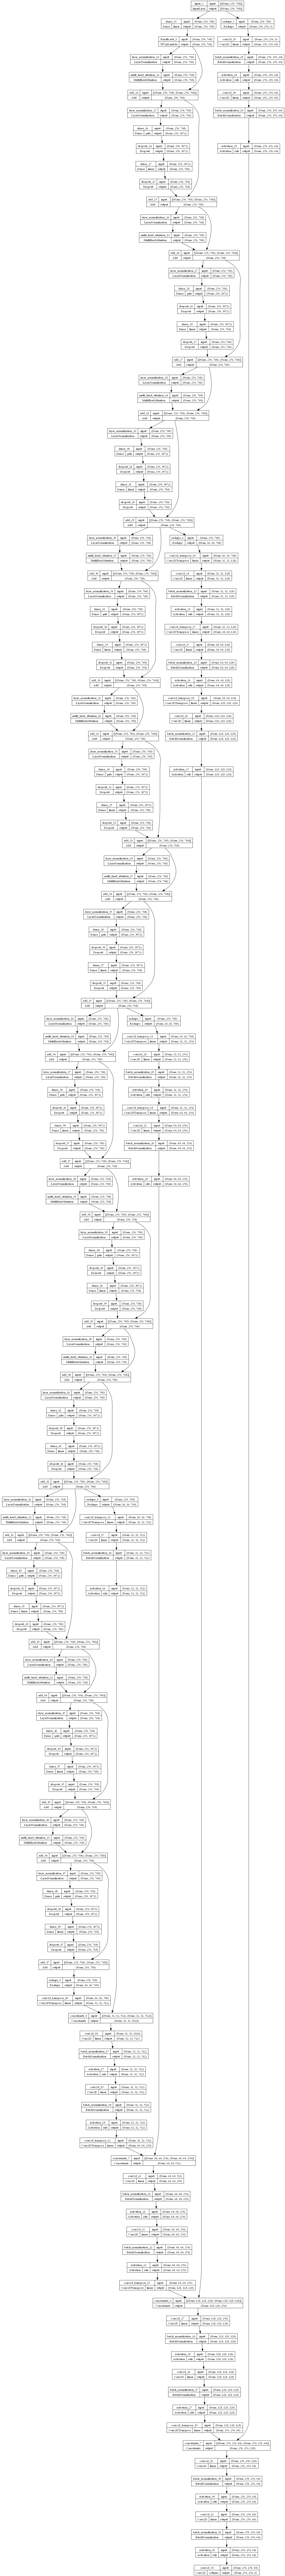

In [31]:
keras.utils.plot_model(
    UNETR_model,
    to_file='UNETR_model.png',
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    show_layer_activations=True,
    dpi=100
)

In [ ]:
# # metrics
# def dice_coef(y_true, y_pred):
#     y_truef = K.flatten(y_true)
#     y_predf = K.flatten(y_pred)
#     And = K.sum(y_truef * y_predf)
#     return ((2* And + 1.0) / (K.sum(y_truef) + K.sum(y_predf) + 1.0)) 

# metrics=['accuracy', dice_coef]

In [32]:
UNETR_model.compile(optimizer='adam', loss = "categorical_crossentropy" , metrics = ['accuracy'])

checkpoint = ModelCheckpoint("UNETR.weights.h5",monitor="val_acc", save_best_only=True, save_weights_only=True)
early_stopping = EarlyStopping(monitor='val_loss',min_delta=0, patience=5, verbose=1, restore_best_weights=False)
reduce_lr = ReduceLROnPlateau(monitor='val_loss',factor=1e-1, patience=5, verbose=1, min_lr = 2e-6)
callbacks_list = [early_stopping,checkpoint,reduce_lr]

In [22]:
history = UNETR_model.fit(x_train, y_train, batch_size = 16, verbose=1, epochs= 50, validation_data=(x_test, y_test), callbacks = callbacks_list, shuffle=True)

Epoch 1/50
34/34 [==============================] - ETA: 0s - loss: 1.1679 - accuracy: 0.6174

34/34 [==============================] - 172s 3s/step - loss: 1.1679 - accuracy: 0.6174 - val_loss: 69.6661 - val_accuracy: 0.4312 - lr: 0.0010
Epoch 2/50
34/34 [==============================] - ETA: 0s - loss: 0.9003 - accuracy: 0.6782

34/34 [==============================] - 48s 1s/step - loss: 0.9003 - accuracy: 0.6782 - val_loss: 17.0005 - val_accuracy: 0.5458 - lr: 0.0010
Epoch 3/50
34/34 [==============================] - ETA: 0s - loss: 0.8442 - accuracy: 0.6964

34/34 [==============================] - 49s 1s/step - loss: 0.8442 - accuracy: 0.6964 - val_loss: 9.6457 - val_accuracy: 0.6200 - lr: 0.0010
Epoch 4/50
34/34 [==============================] - ETA: 0s - loss: 0.8122 - accuracy: 0.7034

34/34 [==============================] - 49s 1s/step - loss: 0.8122 - accuracy: 0.7034 - val_loss: 16.6943 - val_accuracy: 0.5365 - lr: 0.0010
Epoch 5/50
34/34 [==============================] - ETA: 0s - loss: 0.8215 - accuracy: 0.7007

34/34 [==============================] - 49s 1s/step - loss: 0.8215 - accuracy: 0.7007 - val_loss: 11.1500 - val_accuracy: 0.5408 - lr: 0.0010
Epoch 6/50
34/34 [==============================] - ETA: 0s - loss: 0.8148 - accuracy: 0.7014

34/34 [==============================] - 48s 1s/step - loss: 0.8148 - accuracy: 0.7014 - val_loss: 5.4697 - val_accuracy: 0.5905 - lr: 0.0010
Epoch 7/50
34/34 [==============================] - ETA: 0s - loss: 0.7918 - accuracy: 0.7100

34/34 [==============================] - 49s 1s/step - loss: 0.7918 - accuracy: 0.7100 - val_loss: 2.5574 - val_accuracy: 0.6328 - lr: 0.0010
Epoch 8/50
34/34 [==============================] - ETA: 0s - loss: 0.7700 - accuracy: 0.7210

34/34 [==============================] - 49s 1s/step - loss: 0.7700 - accuracy: 0.7210 - val_loss: 3.7382 - val_accuracy: 0.6157 - lr: 0.0010
Epoch 9/50
34/34 [==============================] - ETA: 0s - loss: 0.7656 - accuracy: 0.7172

34/34 [==============================] - 49s 1s/step - loss: 0.7656 - accuracy: 0.7172 - val_loss: 5.0252 - val_accuracy: 0.5333 - lr: 0.0010
Epoch 10/50
34/34 [==============================] - ETA: 0s - loss: 0.7726 - accuracy: 0.7135

34/34 [==============================] - 49s 1s/step - loss: 0.7726 - accuracy: 0.7135 - val_loss: 2.4387 - val_accuracy: 0.6064 - lr: 0.0010
Epoch 11/50
34/34 [==============================] - ETA: 0s - loss: 0.7587 - accuracy: 0.7187

34/34 [==============================] - 49s 1s/step - loss: 0.7587 - accuracy: 0.7187 - val_loss: 1.3858 - val_accuracy: 0.6580 - lr: 0.0010
Epoch 12/50
34/34 [==============================] - ETA: 0s - loss: 0.7593 - accuracy: 0.7181

34/34 [==============================] - 48s 1s/step - loss: 0.7593 - accuracy: 0.7181 - val_loss: 5.1996 - val_accuracy: 0.5333 - lr: 0.0010
Epoch 13/50
34/34 [==============================] - ETA: 0s - loss: 0.7589 - accuracy: 0.7229

34/34 [==============================] - 50s 1s/step - loss: 0.7589 - accuracy: 0.7229 - val_loss: 4.4996 - val_accuracy: 0.5333 - lr: 0.0010
Epoch 14/50
34/34 [==============================] - ETA: 0s - loss: 0.7365 - accuracy: 0.7316

34/34 [==============================] - 50s 1s/step - loss: 0.7365 - accuracy: 0.7316 - val_loss: 1.3524 - val_accuracy: 0.6425 - lr: 0.0010
Epoch 15/50
34/34 [==============================] - ETA: 0s - loss: 0.7345 - accuracy: 0.7286

34/34 [==============================] - 50s 1s/step - loss: 0.7345 - accuracy: 0.7286 - val_loss: 2.0504 - val_accuracy: 0.6308 - lr: 0.0010
Epoch 16/50
34/34 [==============================] - ETA: 0s - loss: 0.7260 - accuracy: 0.7349

34/34 [==============================] - 50s 1s/step - loss: 0.7260 - accuracy: 0.7349 - val_loss: 2.8176 - val_accuracy: 0.5773 - lr: 0.0010
Epoch 17/50
34/34 [==============================] - ETA: 0s - loss: 0.7313 - accuracy: 0.7324

34/34 [==============================] - 49s 1s/step - loss: 0.7313 - accuracy: 0.7324 - val_loss: 2.4752 - val_accuracy: 0.5971 - lr: 0.0010
Epoch 18/50
34/34 [==============================] - ETA: 0s - loss: 0.7463 - accuracy: 0.7264

34/34 [==============================] - 49s 1s/step - loss: 0.7463 - accuracy: 0.7264 - val_loss: 1.6563 - val_accuracy: 0.6537 - lr: 0.0010
Epoch 19/50
34/34 [==============================] - ETA: 0s - loss: 0.7120 - accuracy: 0.7395

34/34 [==============================] - 50s 1s/step - loss: 0.7120 - accuracy: 0.7395 - val_loss: 0.8614 - val_accuracy: 0.7109 - lr: 0.0010
Epoch 20/50
34/34 [==============================] - ETA: 0s - loss: 0.7106 - accuracy: 0.7400

34/34 [==============================] - 49s 1s/step - loss: 0.7106 - accuracy: 0.7400 - val_loss: 0.8901 - val_accuracy: 0.7011 - lr: 0.0010
Epoch 21/50
34/34 [==============================] - ETA: 0s - loss: 0.7089 - accuracy: 0.7423

34/34 [==============================] - 49s 1s/step - loss: 0.7089 - accuracy: 0.7423 - val_loss: 1.0615 - val_accuracy: 0.6757 - lr: 0.0010
Epoch 22/50
34/34 [==============================] - ETA: 0s - loss: 0.7169 - accuracy: 0.7360

34/34 [==============================] - 50s 1s/step - loss: 0.7169 - accuracy: 0.7360 - val_loss: 0.8529 - val_accuracy: 0.7019 - lr: 0.0010
Epoch 23/50
34/34 [==============================] - ETA: 0s - loss: 0.7462 - accuracy: 0.7264

34/34 [==============================] - 50s 1s/step - loss: 0.7462 - accuracy: 0.7264 - val_loss: 2.0534 - val_accuracy: 0.6247 - lr: 0.0010
Epoch 24/50
34/34 [==============================] - ETA: 0s - loss: 0.7140 - accuracy: 0.7397

34/34 [==============================] - 50s 1s/step - loss: 0.7140 - accuracy: 0.7397 - val_loss: 1.2434 - val_accuracy: 0.6449 - lr: 0.0010
Epoch 25/50
34/34 [==============================] - ETA: 0s - loss: 0.7145 - accuracy: 0.7393

34/34 [==============================] - 48s 1s/step - loss: 0.7145 - accuracy: 0.7393 - val_loss: 1.3651 - val_accuracy: 0.6273 - lr: 0.0010
Epoch 26/50
34/34 [==============================] - ETA: 0s - loss: 0.7026 - accuracy: 0.7433

34/34 [==============================] - 50s 1s/step - loss: 0.7026 - accuracy: 0.7433 - val_loss: 1.0243 - val_accuracy: 0.6751 - lr: 0.0010
Epoch 27/50
34/34 [==============================] - ETA: 0s - loss: 0.7052 - accuracy: 0.7421


Epoch 27: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
34/34 [==============================] - 50s 1s/step - loss: 0.7052 - accuracy: 0.7421 - val_loss: 0.8765 - val_accuracy: 0.6947 - lr: 0.0010
Epoch 27: early stopping


pd.DataFrame(history.history).plot()

In [24]:
# evalute model
loss,acc= UNETR_model.evaluate(x_test, y_test, verbose=1)
print("accuracy:", acc)

5/5 [==============================] - 24s 753ms/step - loss: 0.8765 - accuracy: 0.6947
accuracy: 0.6946816444396973


In [26]:
y_pred=UNETR_model.predict(x_test)

5/5 [==============================] - 6s 750ms/step


In [27]:
y_pred_argmax=np.argmax(y_pred, axis=3)
y_test_argmax=np.argmax(y_test, axis=3)

1/1 [==============================] - 0s 61ms/step


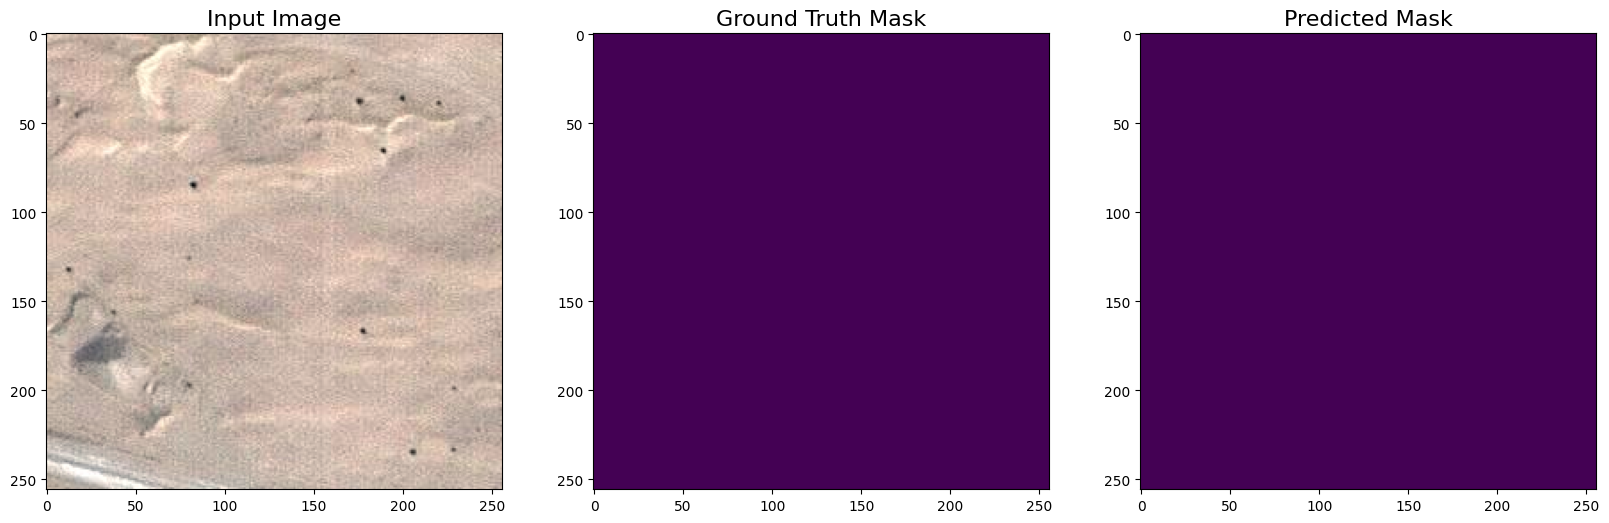

1/1 [==============================] - 0s 62ms/step


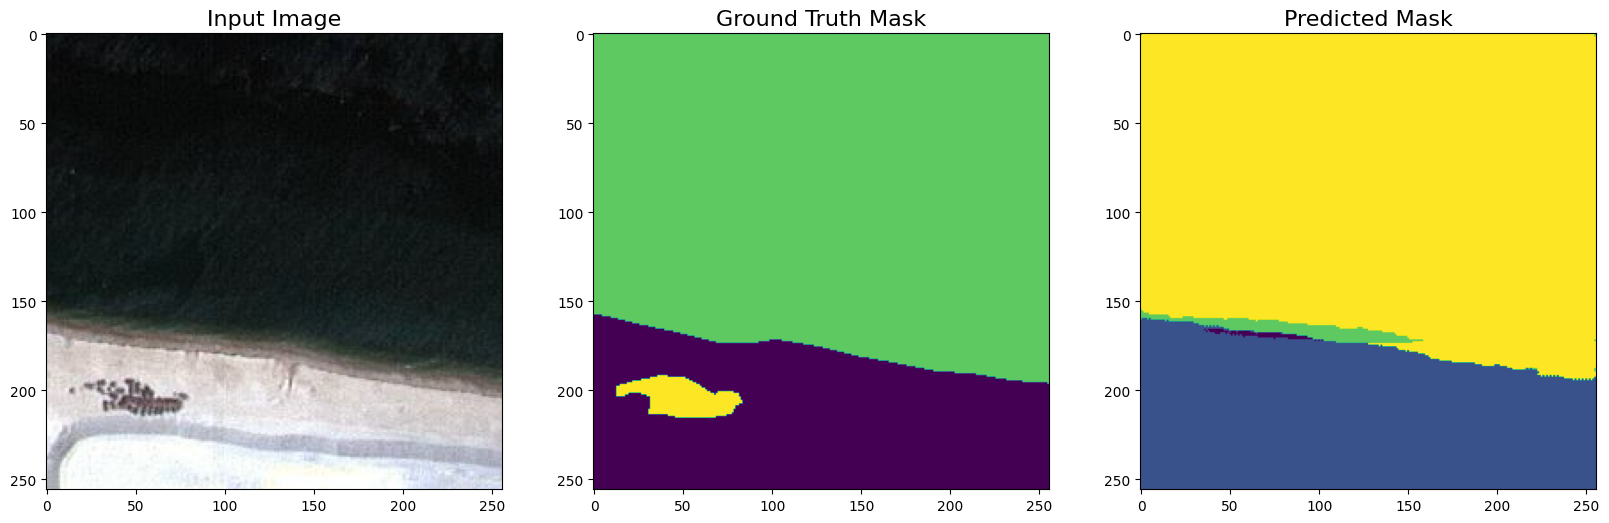

1/1 [==============================] - 0s 63ms/step


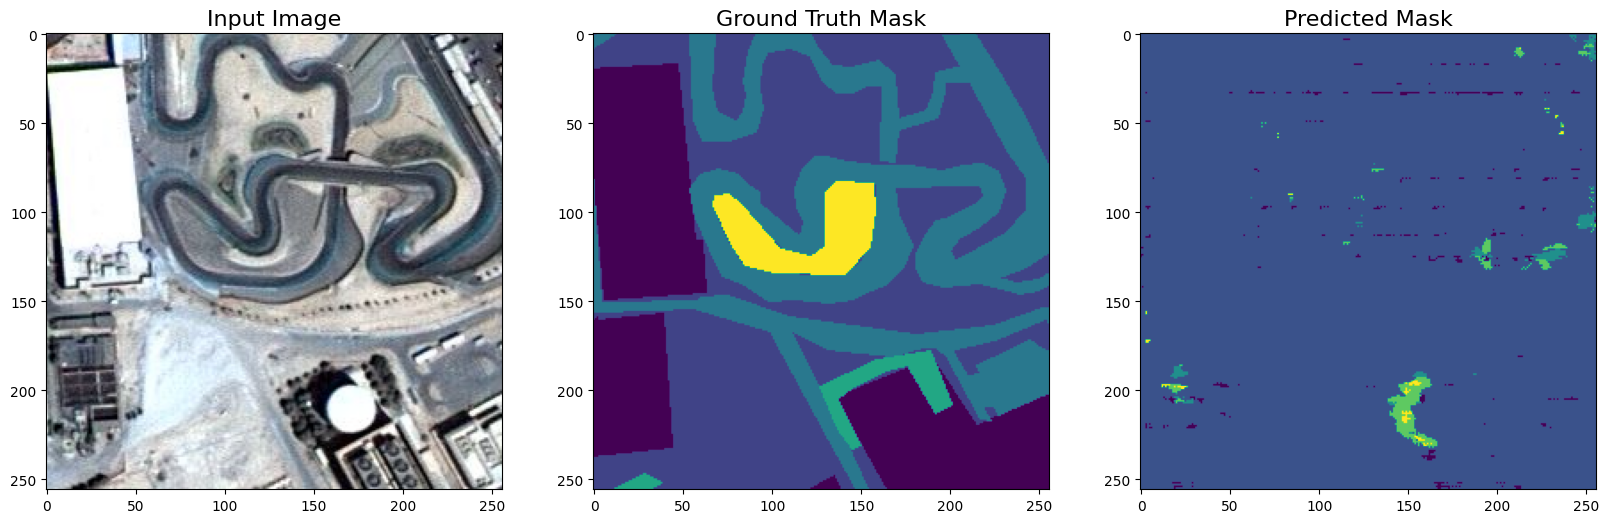

1/1 [==============================] - 0s 61ms/step


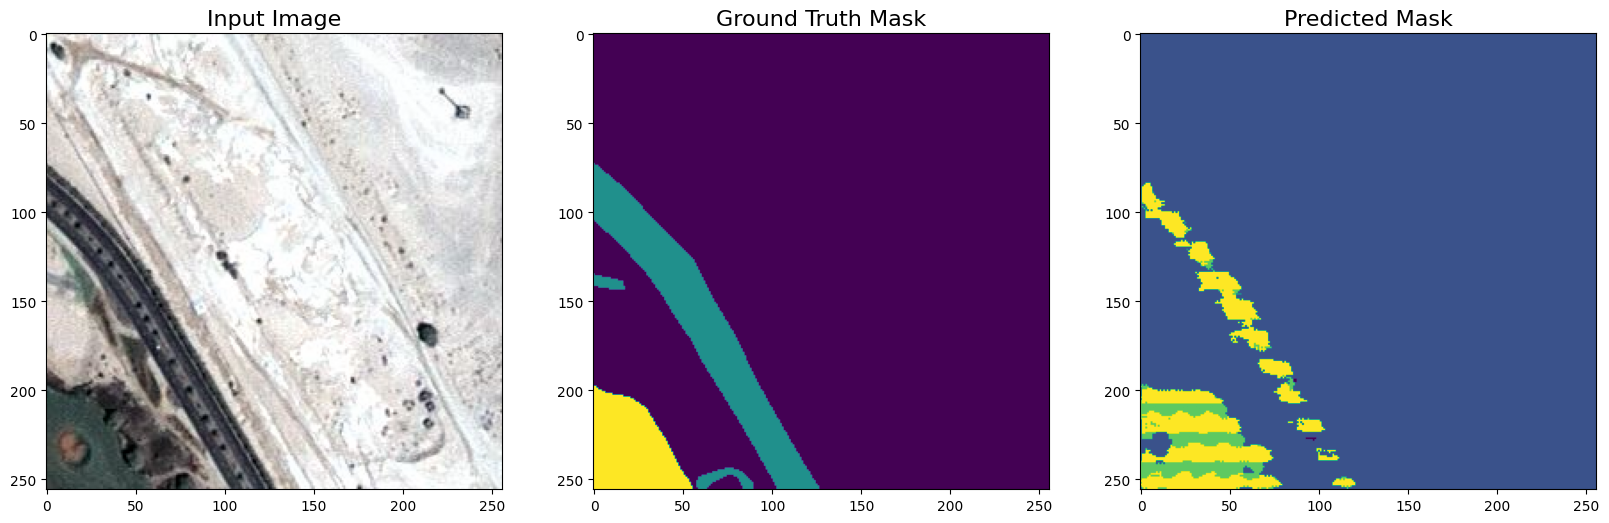

In [ ]:
for i in range(4):
    fig = plt.figure(figsize=(20,8))
    ax1 = fig.add_subplot(1,3,1)
    ax1.imshow(X_test[i])
    ax1.set_title('Input Image', fontdict={'fontsize': 16, 'fontweight': 'medium'})

    ax2 = fig.add_subplot(1,3,2)
    ax2.set_title('Ground Truth Mask', fontdict={'fontsize': 16, 'fontweight': 'medium'})
    ax2.imshow(y_test_argmax[i])

    ax3 = fig.add_subplot(1,3,3)
    ax3.set_title('Predicted Mask', fontdict={'fontsize': 16, 'fontweight': 'medium'})
    ax3.imshow(np.argmax(UNETR_model.predict(np.expand_dims(x_test[i], 0)), axis=3)[0,:,:])

    plt.show()

In [25]:
UNETR_model.save("Multiclass_UNETR_CNN_ViT_Model.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
